In [ ]:
import os
import shutil
import subprocess
import tarfile
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import confusion_matrix

# Mount Google Drive
drive.mount("/content/drive")

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INITIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

DRIVE_PROJECT_DIR = "/content/drive/MyDrive/ai-food-analyzer/"
DRIVE_DATASETS_DIR = "/content/drive/MyDrive/colab_datasets/"
FOOD101_ARCHIVE_PATH = os.path.join(DRIVE_DATASETS_DIR, "food-101.tar.gz")

local_extract_path = "/content/datasets/"
food_dir = os.path.join(local_extract_path, "food-101", "images")
non_food_dir = os.path.join(food_dir, "non_food")

# Output paths
output_model_path = os.path.join(DRIVE_PROJECT_DIR, "model_finetuned.keras")
output_weights_path = os.path.join(DRIVE_PROJECT_DIR, "model_finetuned.weights.h5")
output_plot_path = os.path.join(DRIVE_PROJECT_DIR, "performance_plot_finetuned.png")
output_samples_path = os.path.join(DRIVE_PROJECT_DIR, "dataset_samples.png")
output_cm_path = os.path.join(DRIVE_PROJECT_DIR, "confusion_matrix.png")
output_preds_path = os.path.join(DRIVE_PROJECT_DIR, "final_predictions.png")
class_names_path = os.path.join(DRIVE_PROJECT_DIR, "class_names.txt")

os.makedirs(DRIVE_PROJECT_DIR, exist_ok=True)
os.makedirs(DRIVE_DATASETS_DIR, exist_ok=True)

def find_file(start_dir, filename):
    for root, dirs, files in os.walk(start_dir):
        if filename in files:
            return os.path.join(root, filename)
    return None

def find_folder(start_dir, foldername):
    for root, dirs, files in os.walk(start_dir):
        if foldername in dirs:
            return os.path.join(root, foldername)
    return None

def get_data():
    if not os.path.exists(FOOD101_ARCHIVE_PATH):
        print("Downloading Food-101 dataset to Google Drive...")
        subprocess.run(["wget", "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz", "-O", FOOD101_ARCHIVE_PATH], check=True)

    print("Copying/Extracting Food-101...")
    if os.path.exists(local_extract_path): shutil.rmtree(local_extract_path)
    with tarfile.open(FOOD101_ARCHIVE_PATH, "r:gz") as tar:
        tar.extractall(path=local_extract_path)

    print("Downloading Caltech-101 for 'non_food' class...")
    caltech_url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
    caltech_zip = "/content/caltech101.zip"
    caltech_extract_base = "/content/caltech101_raw"
    if not os.path.exists(caltech_zip):
        subprocess.run(["wget", caltech_url, "-O", caltech_zip], check=True)

    if os.path.exists(caltech_extract_base): shutil.rmtree(caltech_extract_base)
    with zipfile.ZipFile(caltech_zip, "r") as zip_ref:
        zip_ref.extractall(caltech_extract_base)

    inner_tar_path = find_file(caltech_extract_base, "101_ObjectCategories.tar.gz")
    if not inner_tar_path:
        raise FileNotFoundError("Could not find 101_ObjectCategories.tar.gz inside the zip.")

    print(f"Extracting inner tar: {inner_tar_path}")
    with tarfile.open(inner_tar_path, "r:gz") as tar:
        tar.extractall(path=os.path.dirname(inner_tar_path))

    base_caltech = find_folder(caltech_extract_base, "101_ObjectCategories")
    if not base_caltech:
        raise FileNotFoundError("Could not find 101_ObjectCategories folder after extraction.")

    excluded = ["BACKGROUND_Google", "bass", "brain", "crab", "crayfish", "cup", "lobster", "octopus", "pizza", "rooster", "strawberry", "sunflower"]

    print("Constructing 'non_food' class...")
    os.makedirs(non_food_dir, exist_ok=True)
    for category in os.listdir(base_caltech):
        if category in excluded: continue
        cat_path = os.path.join(base_caltech, category)
        if os.path.isdir(cat_path):
            for img in os.listdir(cat_path):
                if img.lower().endswith((".jpg", ".jpeg", ".png")):
                    shutil.move(os.path.join(cat_path, img), os.path.join(non_food_dir, f"{category}_{img}"))
    return food_dir

food_dir = get_data()

Mounted at /content/drive
Copying/Extracting Food-101...


/tmp/ipython-input-2166749436.py:65: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=local_extract_path)


Extracting inner tar: /content/caltech101_raw/caltech-101/101_ObjectCategories.tar.gz


/tmp/ipython-input-2166749436.py:85: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=os.path.dirname(inner_tar_path))


Constructing 'non_food' class...


Found 109027 files belonging to 102 classes.
Using 87222 files for training.
Found 109027 files belonging to 102 classes.
Using 21805 files for validation.


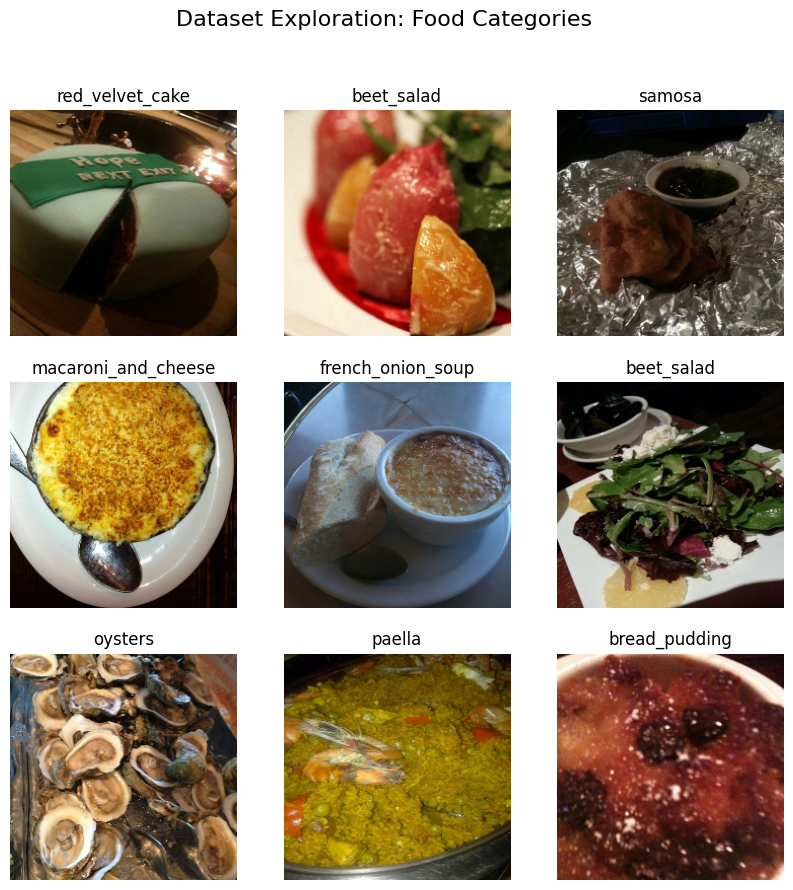

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Phase 1: Transfer Learning ---
Epoch 1/5
2726/2726 ━━━━━━━━━━━━━━━━━━━━ 305s 106ms/step - accuracy: 0.4424 - loss: 2.3675 - val_accuracy: 0.5740 - val_loss: 1.7018
Epoch 2/5
2726/2726 ━━━━━━━━━━━━━━━━━━━━ 274s 93ms/step - accuracy: 0.6169 - loss: 1.4965 - val_accuracy: 0.5858 - val_loss: 1.6906
Epoch 3/5
2726/2726 ━━━━━━━━━━━━━━━━━━━━ 310s 111ms/step - accuracy: 0.6513 - loss: 1.3416 - val_accuracy: 0.5939 - val_loss: 1.6795
Epoch 4/5
2726/2726 ━━━━━━━━━━━━━━━━━━━━ 283s 97ms/step - accuracy: 0.6738 - loss: 1.2435 - val_accuracy: 0.5934 - val_loss: 1.7116
Epoch 5/5
2726/2726 ━━━━━━━━━━━━━━━━━━━━ 232s 85ms/step - accuracy: 0.6911 - loss: 1.1721 - val_accuracy: 0.5879 - val_loss: 1.7427

--- Starting Phase 2: Fine-Tuning ---
Epoch 5/10
2726/2726 ━━━━━━━━━━━━━━━━━━━━ 270s 93ms/step - accuracy: 0.6148 - loss: 1.4942 - val_accuracy: 0.6256 - val_loss: 1.5806
Epoch 6/10
2726/2726 ━━━━━━━━━━━━━━━━━━━━ 268s 98ms/step - accuracy: 0.7

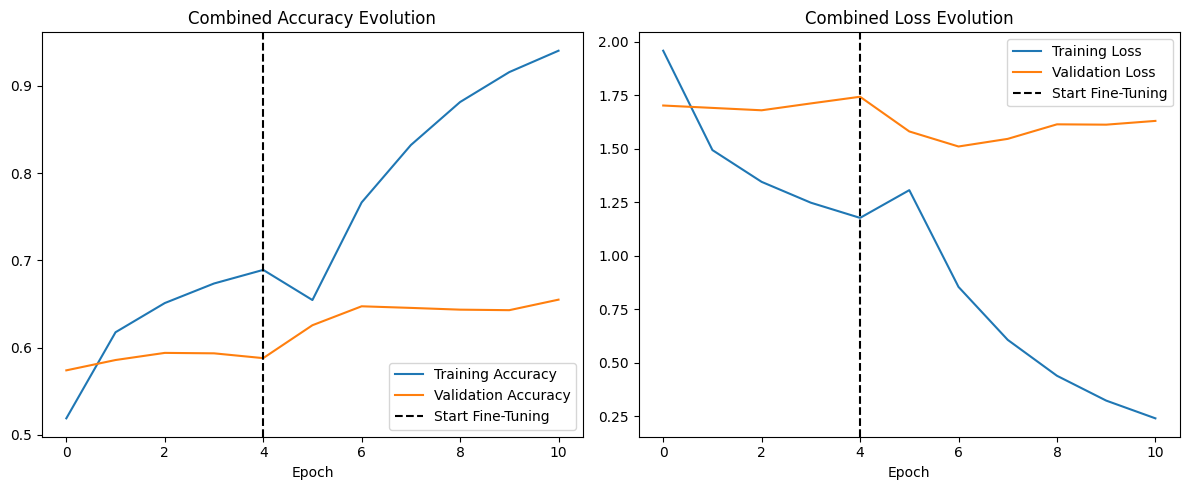

✅ Combined performance plot saved to: /content/drive/MyDrive/ai-food-analyzer/performance_plot_finetuned.png
Generating Confusion Matrix...


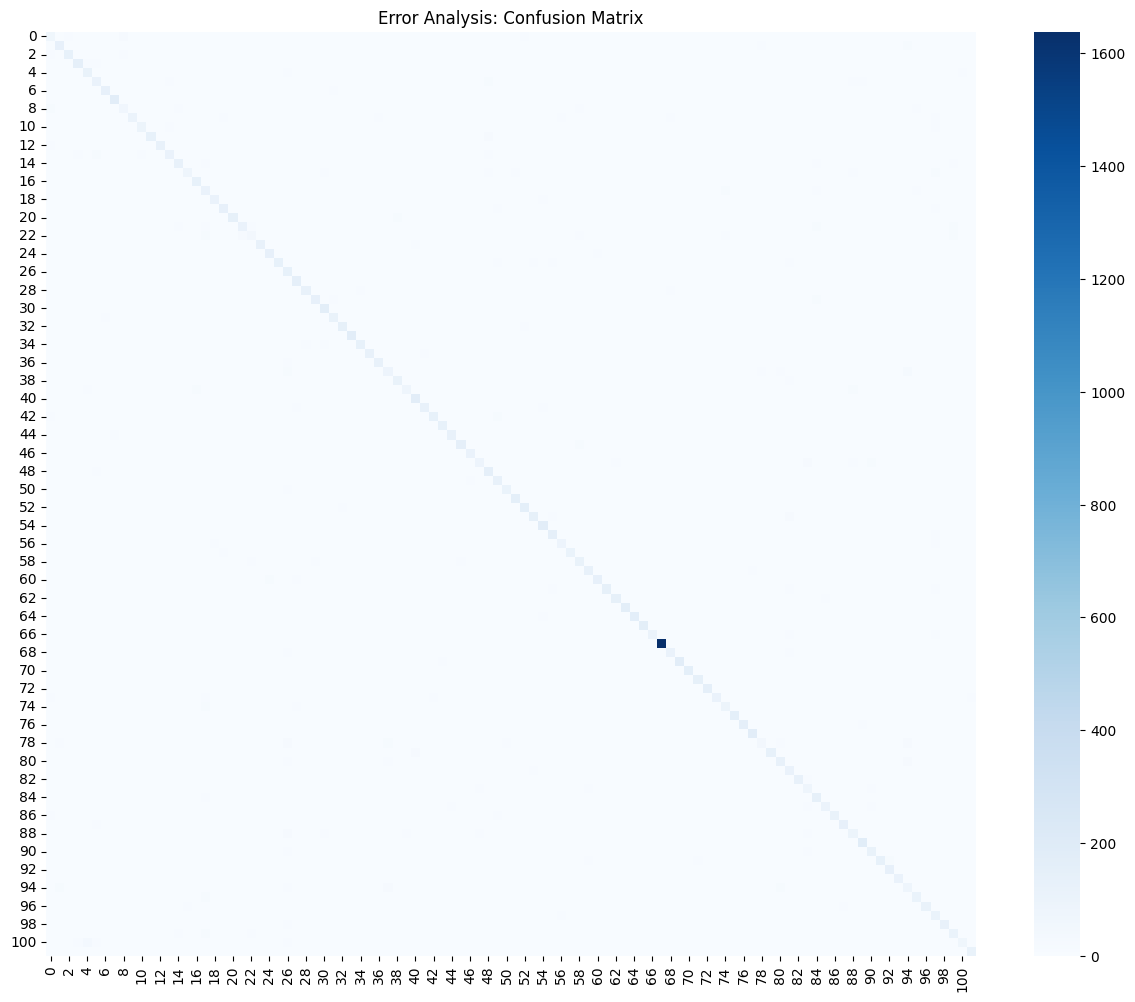

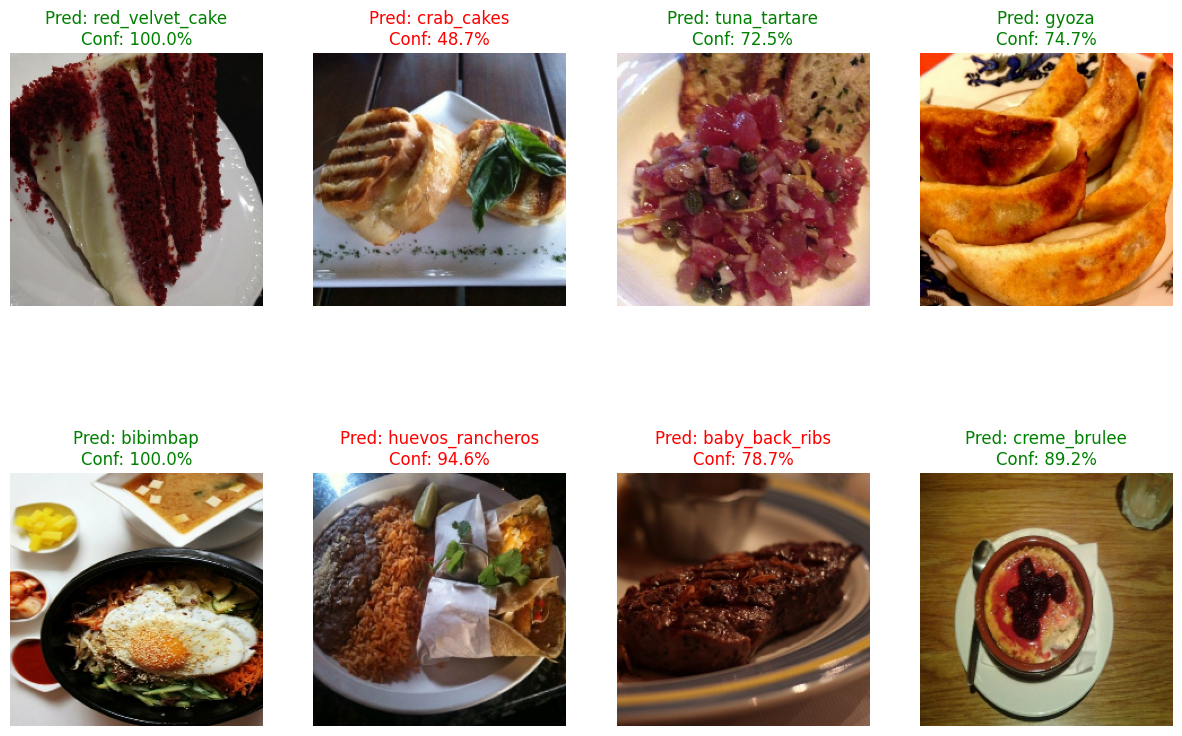

✅ Training Complete. All assets saved to /content/drive/MyDrive/ai-food-analyzer/


In [ ]:
# Create Pipelines
train_data = tf.keras.utils.image_dataset_from_directory(
    food_dir, validation_split=0.2, subset="training", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_data = tf.keras.utils.image_dataset_from_directory(
    food_dir, validation_split=0.2, subset="validation", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE)

class_names = train_data.class_names
with open(class_names_path, "w") as f: f.write("\n".join(class_names))

# Dataset gallery
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Dataset Exploration: Food Categories", fontsize=16)
plt.savefig(output_samples_path)
plt.show()

# Build model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),
    tf.keras.layers.Rescaling(1.0 / 255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Starting Phase 1: Transfer Learning ---")
history = model.fit(train_data, validation_data=val_data, epochs=INITIAL_EPOCHS)

print("\n--- Starting Phase 2: Fine-Tuning ---")
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])
history_fine = model.fit(train_data, epochs=TOTAL_EPOCHS, initial_epoch=history.epoch[-1], validation_data=val_data)

from src.plot import save_performance_plot
save_performance_plot(history, history_fine, INITIAL_EPOCHS, output_plot_path)

print("Generating Confusion Matrix...")
y_true, y_pred = [], []
for images, labels in val_data:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Error Analysis: Confusion Matrix")
plt.savefig(output_cm_path)
plt.show()

plt.figure(figsize=(15, 10))
for images, labels in val_data.take(1):
    preds = model.predict(images, verbose=0)
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        p_idx, t_idx = np.argmax(preds[i]), labels[i].numpy()
        color = "green" if p_idx == t_idx else "red"
        plt.title(f"Pred: {class_names[p_idx]}\nConf: {100*np.max(preds[i]):.1f}%", color=color)
        plt.axis("off")
plt.savefig(output_preds_path)
plt.show()

model.save(output_model_path)
print(f"✅ Training Complete. All assets saved to {DRIVE_PROJECT_DIR}")